# Point Cloud QoE Models

## Joint Communication and Computational Resource Allocation for QoE-driven Point Cloud Video Streaming

In [26]:
def get_distance_weight(g, k, d):
    # p_g,k in equation (5)
    # input: tile k in GOF g, distance d from the viewer to the object
    # output: for simplicity: all tiles have the same distance as d.
    return 1/d


In [27]:
def get_quality_weight(n, N):
    # QT_g,k in equation (5)
    # input: tile k in GOF g
    # output: the ratio of # of points in the tile k (n) to the total # of points in FOV (N)
    return n/N

In [28]:
def get_quality_contribution(g, k, d, r):
    # output: quality contribution of tile k in GOF g with quality r at distance d
    distance_weight = get_distance_weight(g, k, d)
    quality_weight = get_quality_weight(n, N)

    return distance_weight * r * quality_weight


In [29]:
def get_qoe_score (M, R, G, d):
    sum_1 = 0
    sum_2 = 0
    for g in range(G):
        for k in range(M):
            r = 1
            sum_1 += get_quality_contribution(g, k, d, r)
            sum_2 += get_quality_contribution(g, k, d, r) * R/r

    return sum_1/sum_2
    

## Objective metrics for PC compression

In [30]:
import re
import matplotlib.pyplot as plt

In [31]:
def calculate_frame_psnr(file):
    psnr_y = []
    psnr_cb = []
    psnr_cr = []
    psnr_color = []
    psnr_geometry = []

    with open(file) as f:
        lines = f.readlines()

        for line in lines:
            value = line.split(":")
            if len(value) > 1:
                if "c[0],PSNRF" in line:
                    psnr_y.append(float(value[1]))
                    continue

                if "c[1],PSNRF" in line:
                    psnr_cb.append(float(value[1]))
                    continue

                if "c[2],PSNRF" in line:
                    psnr_cr.append(float(value[1]))
                    continue
                if "mseF,PSNR" in line:
                    psnr_geometry.append(float(value[1]))
    
    # psnr_avg = 0
    for y, cb, cr in zip(psnr_y, psnr_cb, psnr_cr):
        psnr_color.append((6*y +cb + cr)/8)
        # psnr_avg += (4*y +cb + cr)/6

    # print("PSNR: ", psnr_frame)
    # f = open("psnr.txt", "a")
    # f.write("{}\t{}\n".format(file.split("/")[-1], psnr_frame))
    return psnr_color, psnr_geometry



In [32]:
result_folder = "./results"
videos = ["longdress", "soldier", "redandblack", "loot"]
qualities = ["r1", "r3", "r5"]
psnr_color = {}
psnr_geometry = {}

for video in videos:
    psnr_color[video] = {}
    psnr_geometry[video] = {}
    for quality in qualities:
        file = "{}/{}_{}_single.txt".format(result_folder, video, quality)
        psnr_color[video][quality], psnr_geometry[video][quality] = calculate_frame_psnr(file)

In [33]:
import numpy as np

video_psnr_color = {}
video_psnr_geometry = {}

for video in videos:
    video_psnr_color[video] = []
    for start in qualities:
        for end in qualities:
            psnr_frames_color = np.concatenate((psnr_color[video][start][:150], psnr_color[video][end][150:]))
            video_psnr_color[video].append(np.average(psnr_frames_color))
            print("{}_{}_{}_color: {}".format(video, start, end, np.average(psnr_frames_color)))

for video in videos:
    video_psnr_geometry[video] = []
    for start in qualities:
        for end in qualities:
            psnr_frames_geometry = np.concatenate((psnr_geometry[video][start][:150], psnr_geometry[video][end][150:]))
            video_psnr_geometry[video].append(np.average(psnr_frames_geometry))
            print("{}_{}_{}_geometry: {}".format(video, start, end, np.average(psnr_frames_geometry)))

longdress_r1_r1_color: 28.667476401124997
longdress_r1_r3_color: 30.825207368166666
longdress_r1_r5_color: 33.201027234625
longdress_r3_r1_color: 30.821573738833333
longdress_r3_r3_color: 32.979304705875
longdress_r3_r5_color: 35.35512457233333
longdress_r5_r1_color: 33.17784998270833
longdress_r5_r3_color: 35.33558094975
longdress_r5_r5_color: 37.71140081620833
soldier_r1_r1_color: 32.957440520374995
soldier_r1_r3_color: 35.04246286033334
soldier_r1_r5_color: 37.37864139945833
soldier_r3_r1_color: 35.048831322208336
soldier_r3_r3_color: 37.13385366216667
soldier_r3_r5_color: 39.47003220129167
soldier_r5_r1_color: 37.391862625916666
soldier_r5_r3_color: 39.47688496587501
soldier_r5_r5_color: 41.813063505
redandblack_r1_r1_color: 33.107968508875004
redandblack_r1_r3_color: 34.90796910491667
redandblack_r1_r5_color: 36.98098880891666
redandblack_r3_r1_color: 34.89844373141666
redandblack_r3_r3_color: 36.69844432745833
redandblack_r3_r5_color: 38.77146403145833
redandblack_r5_r1_color: 37

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


2.8254758062650445 17.618519759476488
2.081635745023016 27.000402684641944


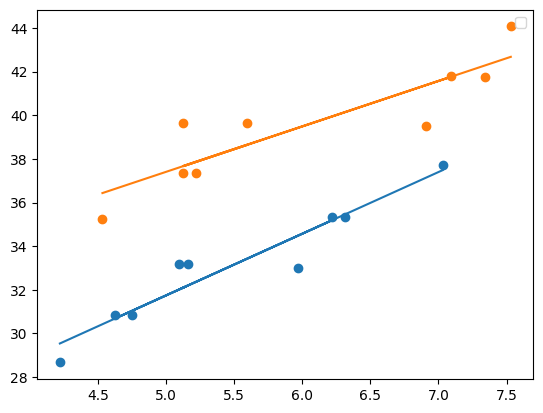

In [34]:
mos_longdress = np.array([4.21875, 4.75, 5.15625, 4.625, 5.96875, 6.21875, 5.09375, 6.3125, 7.03125])
mos_loot = np.array([4.53125, 5.21875, 5.59375, 5.125, 6.90625, 7.09375, 5.125, 7.34375, 7.53125])

plt.scatter(mos_longdress, video_psnr_color[videos[0]])
a, b = np.polyfit(mos_longdress, video_psnr_color[videos[0]], 1)
print(a, b)
plt.plot(mos_longdress, a*mos_longdress+b)

plt.scatter(mos_loot, video_psnr_color[videos[3]])
a, b = np.polyfit(mos_loot, video_psnr_color[videos[3]], 1)
print(a, b)
plt.plot(mos_loot, a*mos_loot+b)
plt.legend()

In [35]:
def linePlot(x, y, outputPath, title, legends, x_title, y_title):

    fig = plt.figure(figsize=(6, 4))

    i = 0
    for x_, y_ in zip(x,y):
        plt.scatter(x_, y_, label=legends[i])
        a, b = np.polyfit(x_, y_, 1)
        print(a, b)
        plt.plot(x_, a*x_+b)
        i += 1

    # plt.ylim(0,10)

    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    
    plt.xlabel(x_title,fontsize=15)
    plt.ylabel(y_title,fontsize=15)
    plt.legend()
    plt.tight_layout()
    plt.savefig("{}/{}.pdf".format(outputPath, title))
    plt.show()

2.8254758062650445 17.618519759476488
2.081635745023016 27.000402684641944


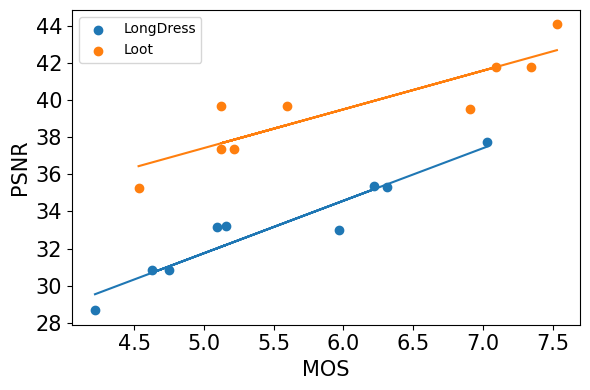

In [36]:
x = [mos_longdress, mos_loot]
y = [video_psnr_color[videos[0]], video_psnr_color[videos[3]]]

linePlot(x, y, "./figures", "PSNR_color",["LongDress", "Loot"], "MOS", "PSNR")

1.5809205805388546 7.331688995032675
1.3578569569141095 5.881806459009396


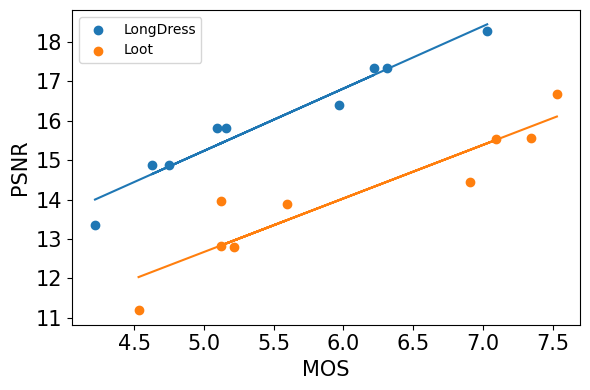

In [37]:
x = [mos_longdress, mos_loot]
y = [video_psnr_geometry[videos[0]], video_psnr_geometry[videos[3]]]

linePlot(x, y, "./figures", "PSNR_geometry",["LongDress", "Loot"], "MOS", "PSNR")

2.8254758062650445 17.618519759476488
2.081635745023016 27.000402684641944
2.8085750261478135 19.621773383684168
2.215303863589529 25.02350545094572


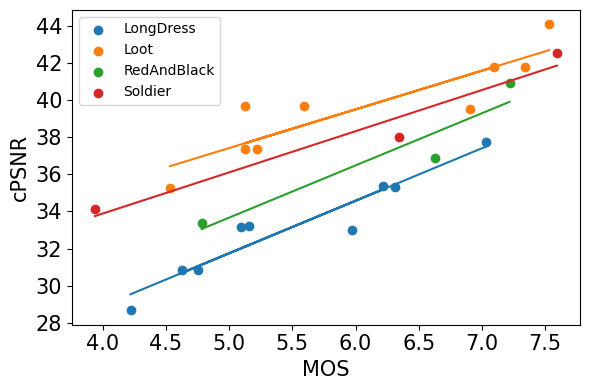

In [38]:
mos_redandblack = np.array([4.78125, 6.625, 7.21875]) # [q1, q2, q3]
mos_soldier = np.array([3.9375, 6.34375, 7.59375]) # [q1, q2, q3]

obj_soldier_color = np.array([34.106847769055555, 38.02213302155556, 42.54009212388889])
obj_redandblack_color = np.array([33.382281832944436, 36.86559818305556, 40.92714999705556])

x = [mos_longdress, mos_loot, mos_redandblack, mos_soldier]
y = [video_psnr_color[videos[0]], video_psnr_color[videos[3]], obj_redandblack_color, obj_soldier_color]

linePlot(x, y, "./figures", "PSNR_color_all",["LongDress", "Loot", "RedAndBlack", "Soldier"], "MOS", "cPSNR")

1.5809205805388546 7.331688995032675
1.3578569569141095 5.881806459009396
1.9619145743536863 4.213300256331974
1.410116959163226 4.814391516641329


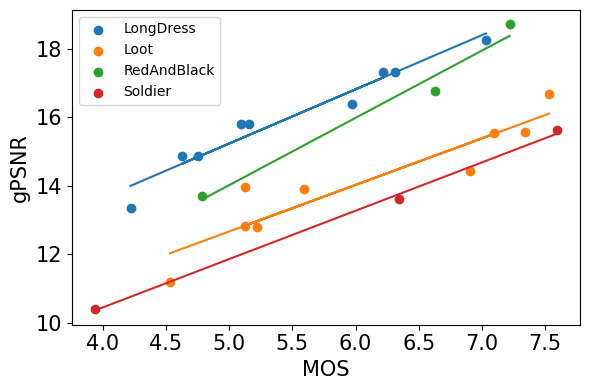

In [39]:
obj_soldier_geometry = np.array([10.416464747266668, 13.614338192366667, 15.618212255333335])
obj_redandblack_geometry = np.array([13.702710880000001, 16.763483676, 18.714365160333333])

x = [mos_longdress, mos_loot, mos_redandblack, mos_soldier]
y = [video_psnr_geometry[videos[0]], video_psnr_geometry[videos[3]], obj_redandblack_geometry, obj_soldier_geometry]

linePlot(x, y, "./figures", "PSNR_geometry_all",["LongDress", "Loot", "RedAndBlack", "Soldier"], "MOS", "gPSNR")

[array([4.21875, 4.75   , 5.15625, 4.625  , 5.96875, 6.21875, 5.09375,
       6.3125 , 7.03125]), array([4.53125, 5.21875, 5.59375, 5.125  , 6.90625, 7.09375, 5.125  ,
       7.34375, 7.53125]), array([4.78125, 6.625  , 7.21875]), array([3.9375 , 6.34375, 7.59375])]
[[4.64, 9.345, 25.71, 9.345, 14.05, 30.415, 25.71, 30.415, 46.78], [2.28, 3.955, 9.48, 3.955, 5.63, 11.155, 9.48, 11.155, 16.68], [3.39, 7.55, 22.9], [4.38, 11.58, 35.29]]
12.457170168523636 -46.51808634120602
3.0116737249125394 -10.030233689314427
6.637501511182753 -29.927821881926253
7.720644735601846 -28.91884154962768


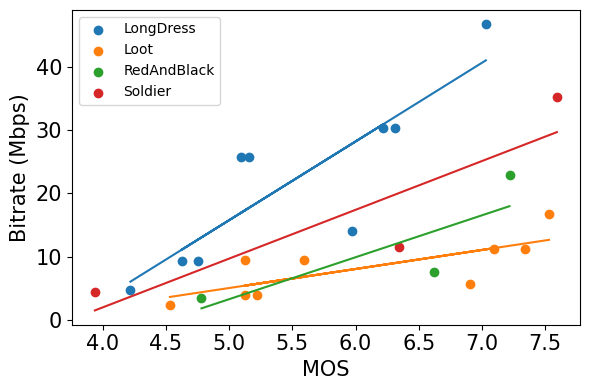

In [40]:
# bitrate
bitrates = {
    'longdress': {'r1': 4.64, 'r3': 14.05, 'r5':46.78},
    'loot': {'r1': 2.28, 'r3': 5.63, 'r5': 16.68},
    'redandblack': {'r1': 3.39, 'r3': 7.55, 'r5': 22.9},
    'soldier': {'r1': 4.38, 'r3': 11.58, 'r5': 35.29}
}

qualities = ['r1', 'r3', 'r5']
videos = ['longdress', 'loot', 'redandblack', 'soldier']
sequence_bitrates = {}

for i in range(len(videos)):
    sequence_bitrates[videos[i]] = []

    if i >= 2:
            sequence_bitrates[videos[i]] = list(bitrates[videos[i]].values())
    else:
        for s_q in qualities:
            for e_q in qualities:
                sequence_bitrates[videos[i]].append((bitrates[videos[i]][s_q] + bitrates[videos[i]][e_q])/2)
    
x = [mos_longdress, mos_loot, mos_redandblack, mos_soldier]
y = [sequence_bitrates['longdress'], sequence_bitrates['loot'], sequence_bitrates['redandblack'], sequence_bitrates['soldier']]

print(x)
print(y)
linePlot(x, y, "./figures", "bitrate_all",["LongDress", "Loot", "RedAndBlack", "Soldier"], "MOS", "Bitrate (Mbps)")

# Correlation Heatmap

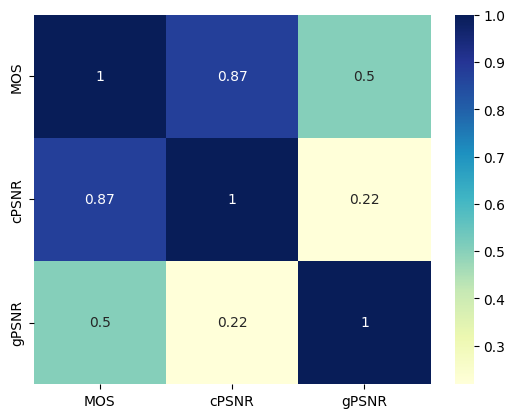

In [41]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

A = np.concatenate([mos_longdress, mos_loot, mos_redandblack, mos_soldier], axis=None)
B = np.concatenate([video_psnr_color[videos[0]], video_psnr_color[videos[3]], obj_redandblack_color, obj_soldier_color], axis=None)
C = np.concatenate([video_psnr_geometry[videos[0]], video_psnr_geometry[videos[3]], obj_redandblack_geometry, obj_soldier_geometry], axis=None)
D = np.concatenate([sequence_bitrates['longdress'], sequence_bitrates['loot'], sequence_bitrates['redandblack'], sequence_bitrates['soldier']], axis=None)

df_correlation = pd.DataFrame({'MOS': A,
                              'cPSNR': B,
                              'gPSNR': C})

corr = df_correlation.corr(method = 'spearman')

sns.heatmap(corr, cmap='YlGnBu', annot = True)
plt.savefig("./figures/correlation_spearman.pdf")
plt.show()


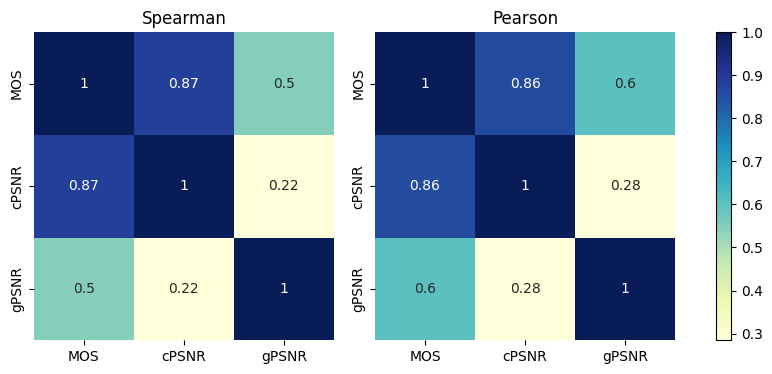

In [42]:
corrs = [df_correlation.corr(method='spearman'), df_correlation.corr(method='pearson')]

fig, axn = plt.subplots(ncols=3, gridspec_kw=dict(width_ratios=[4,4,0.2]), figsize=(9,4))

sns.heatmap(corrs[0], cmap='YlGnBu', annot = True, cbar=False, ax = axn[0])
sns.heatmap(corrs[1], cmap='YlGnBu', annot = True, cbar=False, ax=axn[1])

fig.colorbar(axn[1].collections[0], cax=axn[2])
axn[0].set_title("Spearman")
axn[1].set_title("Pearson")

plt.savefig('./figures/correlation_heatmap.pdf')
plt.show()

# ML/DL models

## Get data

In [2]:
bitrates = {
    'longdress': {'r1': 4.64, 'r3': 14.05, 'r5':46.78},
    'loot': {'r1': 2.28, 'r3': 5.63, 'r5': 16.68},
    'redandblack': {'r1': 3.39, 'r3': 7.55, 'r5': 22.9},
    'soldier': {'r1': 4.38, 'r3': 11.58, 'r5': 35.29}
}
distance_map = {'d125': 1.25, 'd250': 2.5, 'd500': 5}
g_qp_map = {'r1': 32, 'r3': 24, 'r5': 16}
t_qp_map = {'r1': 42, 'r3': 32, 'r5': 22}

In [3]:
import pandas as pd
import numpy as np
# get input data
df = pd.read_csv('./results/ratings.csv')
df

,user,objects,qoe,time
0,19,Soldier_r3_r3_d500,7,2023-03-20-09:29:29+01:00
1,19,Soldier_r3_r3_d250,5,2023-03-20-09:29:47+01:00
2,19,RedAndBlack_r3_r3_d125,5,2023-03-20-09:30:01+01:00
3,19,Soldier_r5_r5_d250,7,2023-03-20-09:30:16+01:00
4,19,Soldier_r5_r5_d500,8,2023-03-20-09:30:30+01:00
...,...,...,...,...
1147,56,Loot_r3_r3_d500,6,2023-03-31-15:47:04+02:00
1148,56,LongDress_r1_r5_d500,5,2023-03-31-15:47:17+02:00
1149,56,Loot_r1_r5_d500,4,2023-03-31-15:47:34+02:00
1150,56,Loot_r3_r1_d500,4,2023-03-31-15:47:45+02:00


In [5]:
df[['object', 'start_quality', 'end_quality', 'distance']] = df.objects.str.split('_', expand=True)
df['object'] = df['object'].str.lower()
df['start_gqp'] = df['start_quality'].map(g_qp_map)
df['start_tqp'] = df['start_quality'].map(t_qp_map)
df['end_gqp'] = df['end_quality'].map(g_qp_map)
df['end_tqp'] = df['end_quality'].map(t_qp_map)
df['distance'] = df['distance'].map(distance_map)
# df['bitrate'] = None
df.to_csv('./results/subjective_objective_results.csv')


In [95]:
for row in np.arange(df.shape[0]):
    df['bitrate'][row] = (bitrates[df['object'][row]][df['start_quality'][row]] + bitrates[df['object'][row]][df['end_quality'][row]])/2

columns = ['start_gqp', 'start_tqp', 'end_gqp', 'end_tqp', 'distance', 'bitrate', 'qoe']
data = df[columns]
data

/var/folders/3b/q3j0_8jx1r16_v2mnl8r9w2w0000gn/T/ipykernel_62043/1205769127.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bitrate'][row] = (bitrates[df['object'][row]][df['start_quality'][row]] + bitrates[df['object'][row]][df['end_quality'][row]])/2


,start_gqp,start_tqp,end_gqp,end_tqp,distance,bitrate,qoe
0,24,32,24,32,5.00,11.58,7
1,24,32,24,32,2.50,11.58,5
2,24,32,24,32,1.25,7.55,5
3,16,22,16,22,2.50,35.29,7
4,16,22,16,22,5.00,35.29,8
...,...,...,...,...,...,...,...
1147,24,32,24,32,5.00,5.63,6
1148,32,42,16,22,5.00,25.71,5
1149,32,42,16,22,5.00,9.48,4
1150,24,32,32,42,5.00,3.955,4


In [96]:
# remove outliers using boxplot method
vpcc_group_columns = ['start_gqp', 'start_tqp', 'end_gqp', 'end_tqp', 'distance', 'bitrate']
configurations = data.groupby(vpcc_group_columns)

def boxplot_outlier_filter(frame):
    """
    Outlier filter using interquantile range (filter below Q1 - 1.5 IQR and above Q3 + 1.5 IQR)

    :param frame: data frame
    :return: filtered frame
    """
    q1 = frame.quantile(0.25)["qoe"]
    q3 = frame.quantile(0.75)["qoe"]
    # interquantile range
    iqr = q3 - q1
    fence_low = q1 - (1.5*iqr)
    fence_high = q3 + (1.5*iqr)
    filterd = (frame["qoe"] >= fence_low) & (frame["qoe"] <= fence_high)
    return frame.loc[filterd]

# for each configuration, filter outliers
df_vpcc_filtered = None
for _, frame in configurations:
    #print(boxplot_outlier_filter(frame))
    df_vpcc_filtered = pd.concat([df_vpcc_filtered, boxplot_outlier_filter(frame)], axis=0)

df_vpcc_filtered = df_vpcc_filtered.reset_index(drop=True)
groups = df_vpcc_filtered.groupby(vpcc_group_columns)


In [97]:
df_vpcc_filtered

,start_gqp,start_tqp,end_gqp,end_tqp,distance,bitrate,qoe
0,16,22,16,22,1.25,22.9,7
1,16,22,16,22,1.25,22.9,5
2,16,22,16,22,1.25,22.9,6
3,16,22,16,22,1.25,22.9,8
4,16,22,16,22,1.25,22.9,5
...,...,...,...,...,...,...,...
1102,32,42,32,42,5.00,4.64,6
1103,32,42,32,42,5.00,4.64,3
1104,32,42,32,42,5.00,4.64,8
1105,32,42,32,42,5.00,4.64,5


In [98]:
from sklearn import preprocessing

def get_train_test_fold(groups, test_group_name, normalize=False):
    """
    Get train/test folds for leave-one-out cross-validation. 

    :param test_group_name: the group name of the test fold
    :param normalize: normalize the data with StandardScaler
    :return: tuple with data frames (train features, train labels, test features, test labels)
    """
    # remove testing group
    training_group_keys = list(groups.groups.keys())
    training_group_keys.remove(test_group_name)
    training_groups = pd.concat(list(map(groups.get_group, training_group_keys)))
   
    y_train = training_groups['qoe']
    # The features must not contain the last column
    x_train = training_groups.drop('qoe', axis=1)

    # single test sample from test group
    y_test = groups.get_group(test_group_name)['qoe'].mean()
    x_test = groups.get_group(test_group_name).head(1).iloc[:,:-1]

    if normalize:
        scaler_x = preprocessing.StandardScaler().fit(x_train)
        x_train = scaler_x.transform(x_train)
        x_test = scaler_x.transform(x_test)

    return x_train, y_train, x_test, y_test

## Classification models

In [99]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import mean_squared_error

seed = 117

models = [
    # RandomForestClassifier(n_estimators=4, random_state=seed),
    # LogisticRegression(C=1, penalty='l2', solver='liblinear', random_state=seed),
    # GradientBoostingClassifier(learning_rate=0.05, max_depth=3, n_estimators=50, random_state=seed),
    DecisionTreeClassifier(max_depth=10, random_state=seed),
    # MLPClassifier(activation='relu', alpha=0.01, hidden_layer_sizes=[10, 20], max_iter=200, solver='adam', random_state=seed),
]

report = None
for group_name in groups.groups.keys():
    x_train, y_train, x_test, y_test = get_train_test_fold(groups, group_name)

    for model in models:
        model.fit(x_train, y_train)

        # result of our model is the prediction of class probabilities per voting category
        class_prob_prediction = model.predict_proba(x_test)

        results = pd.DataFrame(class_prob_prediction, columns = ['prob_1','prob_2','prob_3','prob_4','prob_5', 'prob_6','prob_7','prob_8','prob_9','prob_10'])
        results['test_configuration'] = str(group_name)
        results['model'] = model.__class__.__name__
        results['true_mos'] = y_test
        # convert class probabilities to MOS
        results['predicted_mos'] = results.apply(
            lambda row : (row['prob_1'] + 2 * row['prob_2'] + 3 * row['prob_3'] + 4 * row['prob_4'] + 5 * row['prob_5'] + 6 * row['prob_6'] + 7 * row['prob_7'] + 8 * row['prob_8'] + 9 * row['prob_9'] + 10 * row['prob_10']), 
            axis = 1
        )
        results['mse'] = mean_squared_error(results['true_mos'], results['predicted_mos'])

        report = pd.concat([report, results], axis=0, ignore_index=True)

report

,prob_1,prob_2,prob_3,prob_4,prob_5,prob_6,prob_7,prob_8,prob_9,prob_10,test_configuration,model,true_mos,predicted_mos,mse
0,0.000000,0.000000,0.200000,0.080000,0.360000,0.320000,0.040000,0.000000,0.000000,0.000000,"(16, 22, 16, 22, 1.25, 22.9)",DecisionTreeClassifier,6.187500,4.920000,1.606556
1,0.000000,0.000000,0.062500,0.093750,0.281250,0.125000,0.187500,0.156250,0.031250,0.062500,"(16, 22, 16, 22, 1.25, 35.29)",DecisionTreeClassifier,4.920000,6.187500,1.606556
2,0.000000,0.000000,0.031250,0.093750,0.093750,0.156250,0.312500,0.187500,0.062500,0.062500,"(16, 22, 16, 22, 2.5, 22.9)",DecisionTreeClassifier,6.500000,6.750000,0.062500
3,0.000000,0.000000,0.000000,0.156250,0.125000,0.218750,0.218750,0.156250,0.093750,0.031250,"(16, 22, 16, 22, 2.5, 35.29)",DecisionTreeClassifier,6.750000,6.500000,0.062500
4,0.000000,0.000000,0.000000,0.062500,0.093750,0.125000,0.281250,0.125000,0.218750,0.093750,"(16, 22, 16, 22, 5.0, 16.68)",DecisionTreeClassifier,7.807692,7.343750,0.215242
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.038462,0.307692,0.461538,0.192308,0.000000,"(16, 22, 16, 22, 5.0, 22.9)",DecisionTreeClassifier,7.322581,7.807692,0.235333
6,0.000000,0.000000,0.032258,0.032258,0.032258,0.161290,0.290323,0.258065,0.161290,0.032258,"(16, 22, 16, 22, 5.0, 35.29)",DecisionTreeClassifier,7.724138,7.225806,0.248334
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.137931,0.206897,0.448276,0.206897,0.000000,"(16, 22, 16, 22, 5.0, 46.78)",DecisionTreeClassifier,7.225806,7.724138,0.248334
8,0.000000,0.000000,0.096774,0.000000,0.096774,0.322581,0.193548,0.225806,0.064516,0.000000,"(16, 22, 24, 32, 5.0, 11.155)",DecisionTreeClassifier,7.343750,6.451613,0.795909
9,0.000000,0.000000,0.000000,0.062500,0.093750,0.125000,0.281250,0.125000,0.218750,0.093750,"(16, 22, 24, 32, 5.0, 30.415)",DecisionTreeClassifier,6.451613,7.343750,0.795909


## Regression models

In [100]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import (Ridge, Lasso,LinearRegression)
from sklearn.ensemble import (GradientBoostingRegressor, RandomForestRegressor)
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import  MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing

from sklearn.metrics import mean_squared_error

seed = 117
# report = None

regressor_models = [
    # KNeighborsRegressor(leaf_size=10, n_neighbors=10),
    RandomForestRegressor(random_state=seed),
    # Ridge(random_state=seed),
    # Lasso(random_state=seed),
    GradientBoostingRegressor(random_state=seed),
    DecisionTreeRegressor(random_state=seed),
    # MLPRegressor(random_state=seed),
    # LinearRegression(),
    make_pipeline(PolynomialFeatures(2), preprocessing.StandardScaler(), LinearRegression())
]

for group_name in groups.groups.keys():
    x_train, y_train, x_test, y_test = get_train_test_fold(groups, group_name)

    for model in regressor_models:
        model.fit(x_train, y_train)

        # result is the MOS prediction
        mos_prediction = model.predict(x_test)
        
        results = pd.DataFrame(mos_prediction, columns =['predicted_mos'])
        results['test_configuration'] = str(group_name)
        results['model'] = model.__class__.__name__
        results['true_mos'] = y_test
        results['predicted_mos'] =float(mos_prediction) 
        results['mse'] = mean_squared_error(results['true_mos'], results['predicted_mos'])

        report = pd.concat([report, results], axis=0, ignore_index=True)

report

,prob_1,prob_2,prob_3,prob_4,prob_5,prob_6,prob_7,prob_8,prob_9,prob_10,test_configuration,model,true_mos,predicted_mos,mse
0,0.0,0.0,0.20000,0.08000,0.36000,0.32000,0.04000,0.00000,0.00000,0.00000,"(16, 22, 16, 22, 1.25, 22.9)",DecisionTreeClassifier,6.187500,4.920000,1.606556
1,0.0,0.0,0.06250,0.09375,0.28125,0.12500,0.18750,0.15625,0.03125,0.06250,"(16, 22, 16, 22, 1.25, 35.29)",DecisionTreeClassifier,4.920000,6.187500,1.606556
2,0.0,0.0,0.03125,0.09375,0.09375,0.15625,0.31250,0.18750,0.06250,0.06250,"(16, 22, 16, 22, 2.5, 22.9)",DecisionTreeClassifier,6.500000,6.750000,0.062500
3,0.0,0.0,0.00000,0.15625,0.12500,0.21875,0.21875,0.15625,0.09375,0.03125,"(16, 22, 16, 22, 2.5, 35.29)",DecisionTreeClassifier,6.750000,6.500000,0.062500
4,0.0,0.0,0.00000,0.06250,0.09375,0.12500,0.28125,0.12500,0.21875,0.09375,"(16, 22, 16, 22, 5.0, 16.68)",DecisionTreeClassifier,7.807692,7.343750,0.215242
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(32, 42, 32, 42, 5.0, 4.38)",Pipeline,3.937500,4.212860,0.075823
176,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(32, 42, 32, 42, 5.0, 4.64)",RandomForestRegressor,4.064516,3.922803,0.020083
177,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(32, 42, 32, 42, 5.0, 4.64)",GradientBoostingRegressor,4.064516,4.036674,0.000775
178,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(32, 42, 32, 42, 5.0, 4.64)",DecisionTreeRegressor,4.064516,3.937500,0.016133


## Aggregate results

In [101]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score as R2
import math

model_performance = None

for model, group_content in report.groupby('model'):
    single_model_performance = pd.DataFrame(
        data=
        [[
            model,
            R2(group_content['true_mos'], group_content['predicted_mos']),
            mean_squared_error(group_content['true_mos'], group_content['predicted_mos']),
            math.sqrt(mean_squared_error(group_content['true_mos'], group_content['predicted_mos'])),
            mean_absolute_error(group_content['true_mos'], group_content['predicted_mos'])
        ]],
        columns=
        [
            "model",
            "r2_score",
            "mse",
            "rmse",
            "mae"
        ]
    )
    model_performance = pd.concat([model_performance, single_model_performance], axis=0, ignore_index=True)

model_performance = model_performance.sort_values(["r2_score", "mse", "mae"], ascending=False).reset_index(drop=True)
model_performance

,model,r2_score,mse,rmse,mae
0,GradientBoostingRegressor,0.858174,0.287361,0.536061,0.417536
1,RandomForestRegressor,0.838444,0.327338,0.572135,0.453489
2,DecisionTreeClassifier,0.815524,0.373777,0.611373,0.512783
3,DecisionTreeRegressor,0.795368,0.414616,0.643907,0.527169
4,Pipeline,0.765028,0.476089,0.689992,0.511555


In [102]:
report.to_csv('performance_per_model.csv', index=False)
model_performance.to_csv('models_scores.csv', index=False)

In [201]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})

for model, group_content in report.groupby('model'):
    if model == "GradientBoostingRegressor": 
        # Generate the scatter plot
        plt.figure(figsize=(6, 4))
        plt.scatter(group_content['true_mos'], group_content['predicted_mos']) 

        # Add y=x line to the plot
        plt.plot([0, 10], [0, 10], color = 'red')

        # Label the axes
        plt.xlabel('Perceived MOS')
        plt.ylabel('Predicted MOS')
        plt.tight_layout()
        plt.savefig('./figures/predicted_and_true_distribution_GBR.pdf')  
        plt.show()

NameError: name 'report' is not defined

In [119]:
# calculate correlation
# df_correlation = pd.DataFrame({'MOS': A,
#                               'cPSNR': B,
#                               'gPSNR': C})

# corr = df_correlation.corr(method = 'spearman')
gbr_data = report[report['model'] == 'GradientBoostingRegressor']
gbr_data_corr = pd.DataFrame({'MOS': gbr_data['true_mos'],
                             'predictedMos': gbr_data['predicted_mos']})
gbr_data_corr.corr(method='pearson')

,MOS,predictedMos
MOS,1.000000,0.926948
predictedMos,0.926948,1.000000


In [55]:
regressor_models = [
    GradientBoostingRegressor(random_state=seed),
]

dict = { "Start G-QP": [],
        "Start T-QP": [],
        "End G-QP": [],
        "End T-QP": [],
        "View. distance": [],
        "Bitrate": []
}
feature_importances = pd.DataFrame(dict)


for group_name in groups.groups.keys():
    x_train, y_train, x_test, y_test = get_train_test_fold(groups,group_name)

    for model in regressor_models:
        model.fit(x_train, y_train)

        # result is the MOS prediction
        mos_prediction = model.predict(x_test)
        
        results = pd.DataFrame(mos_prediction, columns =['predicted_mos'])
        results['test_configuration'] = str(group_name)
        results['model'] = model.__class__.__name__
        results['true_mos'] = y_test
        results['predicted_mos'] =float(mos_prediction) 
        results['mse'] = mean_squared_error(results['true_mos'], results['predicted_mos'])

        feature_importances.loc[len(feature_importances.index)] = model.feature_importances_

        # report = pd.concat([report, results], axis=0, ignore_index=True)

# report
feature_importances

,Start G-QP,Start T-QP,End G-QP,End T-QP,View. distance,Bitrate
0,0.044202,0.152959,0.240372,0.279748,0.235756,0.046962
1,0.106695,0.102504,0.314625,0.231179,0.197303,0.047695
2,0.076833,0.110841,0.240474,0.276921,0.239756,0.055174
3,0.060463,0.136664,0.028592,0.476978,0.243450,0.053853
4,0.053714,0.134070,0.123066,0.388749,0.247633,0.052767
5,0.092079,0.098154,0.201013,0.306387,0.247440,0.054926
6,0.100016,0.086124,0.076944,0.434766,0.242735,0.059415
7,0.098636,0.094755,0.126766,0.378864,0.245714,0.055265
8,0.081289,0.095447,0.164035,0.357934,0.245428,0.055867
9,0.086412,0.129135,0.112553,0.377501,0.246598,0.047802


In [56]:
feature_importances.mean()

Start G-QP        0.094394
Start T-QP        0.103196
End G-QP          0.193367
End T-QP          0.320502
View. distance    0.236317
Bitrate           0.052225
dtype: float64

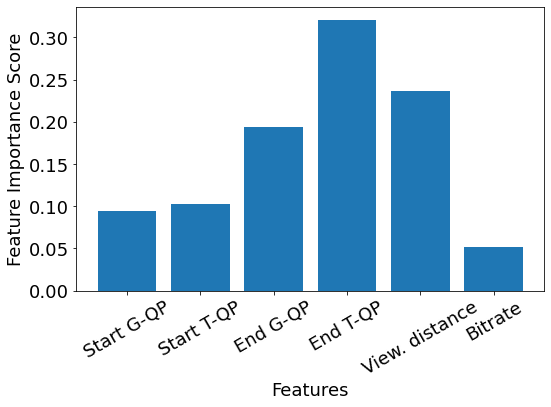

In [124]:
plt.rcParams.update({'font.size': 18})
fig, ax = plt.subplots(figsize=(8,6))
# feature_importances.mean().plot.bar()
plt.bar(np.arange(feature_importances.shape[1]),
        feature_importances.mean(),
        # yerr=[feature_importances.mean()-feature_importances.min(), feature_importances.max()-feature_importances.mean()], capsize=6)
        # yerr=feature_importances.std(),
        capsize=6)

# print(np.concatenate((['a'], dict.keys()), axis=0))
ax.set_xticks(range(len(dict.keys())))
ax.set_xticklabels(labels=dict.keys(), rotation=30)
ax.set_xlabel('Features')
ax.set_ylabel('Feature Importance Score')
plt.tight_layout()
plt.savefig('./figures/feature_importances.pdf')

## Parameter tuning

### GradientBoostingRegressor

In [58]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import (Ridge, Lasso,LinearRegression)
from sklearn.ensemble import (GradientBoostingRegressor, RandomForestRegressor)
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import  MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing

from sklearn.metrics import mean_squared_error

seed = 117
report = None

learning_rates = [0.5, 0.25, 0.1, 0.05, 0.01]
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100]
max_depths = np.linspace(1, 15, 15, endpoint=True)
min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)

train_results = []
test_results = []

for group_name in groups.groups.keys():
    x_train, y_train, x_test, y_test = get_train_test_fold(groups, group_name)

    for learning_rate in learning_rates:
        for n_estimator in n_estimators:
            for max_depth in max_depths:
                for min_samples_split in min_samples_splits:
                    for min_samples_leaf in min_samples_leafs:
                        model = GradientBoostingRegressor(random_state=seed,
                                                learning_rate=learning_rate,
                                                n_estimators=n_estimator,
                                                max_depth=max_depth,
                                                min_samples_split=min_samples_split,
                                                min_samples_leaf=min_samples_leaf,
                                                # min_samples_leaf=0.1,
                                                )
                        model.fit(x_train, y_train)

                        # result is the MOS prediction
                        mos_prediction = model.predict(x_test)
                        
                        results = pd.DataFrame(mos_prediction, columns =['predicted_mos'])
                        results['test_configuration'] = str(group_name)
                        # results['model'] = model.__class__.__name__
                        results['learning_rate'] = learning_rate
                        results['n_estimator'] = n_estimator
                        results['max_depth'] = max_depth
                        results['min_samples_split'] = min_samples_split
                        results['min_samples_leaf'] = min_samples_leaf

                        results['true_mos'] = y_test
                        results['predicted_mos'] =float(mos_prediction) 
                        results['mse'] = mean_squared_error(results['true_mos'], results['predicted_mos'])

                        report = pd.concat([report, results], axis=0, ignore_index=True)

# report

InvalidParameterError: The 'max_depth' parameter of GradientBoostingRegressor must be an int in the range [1, inf) or None. Got 1.0 instead.

In [ ]:
report.to_csv('performance_gbr.csv', index=False)
# model_performance.to_csv('models_scores_gbr.csv', index=False)

In [ ]:
report

,predicted_mos,test_configuration,learning_rate,n_estimator,max_depth,min_samples_split,min_samples_leaf,true_mos,mse
0,5.828803,"(16, 22, 16, 22, 1.25, 22.9)",0.50,1,1.0,0.1,0.1,6.187500,0.128664
1,5.828803,"(16, 22, 16, 22, 1.25, 22.9)",0.50,1,1.0,0.1,0.2,6.187500,0.128664
2,5.828803,"(16, 22, 16, 22, 1.25, 22.9)",0.50,1,1.0,0.1,0.3,6.187500,0.128664
3,5.897497,"(16, 22, 16, 22, 1.25, 22.9)",0.50,1,1.0,0.1,0.4,6.187500,0.084102
4,5.453953,"(16, 22, 16, 22, 1.25, 22.9)",0.50,1,1.0,0.1,0.5,6.187500,0.538090
...,...,...,...,...,...,...,...,...,...
1079995,4.561512,"(32, 42, 32, 42, 5.0, 4.64)",0.01,100,15.0,1.0,0.1,4.064516,0.247005
1079996,4.559635,"(32, 42, 32, 42, 5.0, 4.64)",0.01,100,15.0,1.0,0.2,4.064516,0.245142
1079997,4.559635,"(32, 42, 32, 42, 5.0, 4.64)",0.01,100,15.0,1.0,0.3,4.064516,0.245142
1079998,4.950289,"(32, 42, 32, 42, 5.0, 4.64)",0.01,100,15.0,1.0,0.4,4.064516,0.784594


In [ ]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score as R2
import math

model_performance = None

for features, group_content in report.groupby(['learning_rate', 'n_estimator', 'max_depth', 'min_samples_split', 'min_samples_leaf']):
    single_model_performance = pd.DataFrame(
        data=
        [[
            features,
            R2(group_content['true_mos'], group_content['predicted_mos']),
            mean_squared_error(group_content['true_mos'], group_content['predicted_mos']),
            math.sqrt(mean_squared_error(group_content['true_mos'], group_content['predicted_mos'])),
            mean_absolute_error(group_content['true_mos'], group_content['predicted_mos'])
        ]],
        columns=
        [
            'features',
            "r2_score",
            "mse",
            "rmse",
            "mae"
        ]
    )
    model_performance = pd.concat([model_performance, single_model_performance], axis=0, ignore_index=True)

model_performance = model_performance.sort_values(["r2_score", "mse", "mae"], ascending=False).reset_index(drop=True)
model_performance

,features,r2_score,mse,rmse,mae
0,"(0.5, 100, 1.0, 0.1, 0.1)",0.913599,0.175062,0.418404,0.336917
1,"(0.5, 100, 1.0, 0.2, 0.1)",0.913599,0.175062,0.418404,0.336917
2,"(0.5, 100, 1.0, 0.30000000000000004, 0.1)",0.913599,0.175062,0.418404,0.336917
3,"(0.5, 100, 1.0, 0.4, 0.1)",0.913599,0.175062,0.418404,0.336917
4,"(0.5, 100, 1.0, 0.5, 0.1)",0.913599,0.175062,0.418404,0.336917
...,...,...,...,...,...
29995,"(0.5, 100, 15.0, 0.6, 0.5)",-0.056637,2.140911,1.463185,1.219671
29996,"(0.5, 100, 15.0, 0.7000000000000001, 0.5)",-0.056637,2.140911,1.463185,1.219671
29997,"(0.5, 100, 15.0, 0.8, 0.5)",-0.056637,2.140911,1.463185,1.219671
29998,"(0.5, 100, 15.0, 0.9, 0.5)",-0.056637,2.140911,1.463185,1.219671


### RandomForestRegressor model

In [60]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score as R2
import math

def get_best_performance(report, groupby):
    model_performance = None

    for features, group_content in report.groupby(groupby):
        single_model_performance = pd.DataFrame(
            data=
            [[
                features,
                R2(group_content['true_mos'], group_content['predicted_mos']),
                mean_squared_error(group_content['true_mos'], group_content['predicted_mos']),
                math.sqrt(mean_squared_error(group_content['true_mos'], group_content['predicted_mos'])),
                mean_absolute_error(group_content['true_mos'], group_content['predicted_mos'])
            ]],
            columns=
            [
                'features',
                "r2_score",
                "mse",
                "rmse",
                "mae"
            ]
        )
        model_performance = pd.concat([model_performance, single_model_performance], axis=0, ignore_index=True)

    model_performance = model_performance.sort_values(["r2_score", "mse", "mae"], ascending=False).reset_index(drop=True)
    return model_performance

In [61]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import (Ridge, Lasso,LinearRegression)
from sklearn.ensemble import (GradientBoostingRegressor, RandomForestRegressor)
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import  MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing

from sklearn.metrics import mean_squared_error

seed = 117
report = None

n_estimators = [1, 2, 4, 8, 16, 32, 64, 128]
max_depths = np.arange(10, 121, 10)
min_samples_splits = np.arange(0.1, 1, 0.1)
min_samples_leafs = np.arange(1, 6)


# n_estimators = [1]
# max_depths = [1]
# min_samples_splits = [1]
# min_samples_leafs = [1]

train_results = []
test_results = []

for group_name in groups.groups.keys():
    x_train, y_train, x_test, y_test = get_train_test_fold(groups, group_name)

    for n_estimator in n_estimators:
        for max_depth in max_depths:
            for min_samples_split in min_samples_splits:
                for min_samples_leaf in min_samples_leafs:
                    model = RandomForestRegressor(random_state=seed,
                                            n_estimators=n_estimator,
                                            max_depth=max_depth,
                                            min_samples_split=min_samples_split,
                                            min_samples_leaf=min_samples_leaf,
                                            n_jobs=-1
                                            )
                    model.fit(x_train, y_train)

                    # result is the MOS prediction
                    mos_prediction = model.predict(x_test)
                    
                    results = pd.DataFrame(mos_prediction, columns =['predicted_mos'])
                    results['test_configuration'] = str(group_name)
                    # results['model'] = model.__class__.__name__
                    results['n_estimator'] = n_estimator
                    results['max_depth'] = max_depth
                    results['min_samples_split'] = min_samples_split
                    results['min_samples_leaf'] = min_samples_leaf

                    results['true_mos'] = y_test
                    results['predicted_mos'] =float(mos_prediction) 
                    results['mse'] = mean_squared_error(results['true_mos'], results['predicted_mos'])

                    report = pd.concat([report, results], axis=0, ignore_index=True)

# report

In [62]:
report.to_csv('performance_randomForestRegressor.csv', index=False)
# model_performance.to_csv('models_scores_gbr.csv', index=False)

In [63]:
get_best_performance(report, ['n_estimator', 'max_depth', 'min_samples_split', 'min_samples_leaf'])

,features,r2_score,mse,rmse,mae
0,"(8, 30, 0.1, 1)",0.834321,0.335691,0.579389,0.490741
1,"(8, 40, 0.1, 1)",0.834321,0.335691,0.579389,0.490741
2,"(8, 90, 0.1, 4)",0.834321,0.335691,0.579389,0.490741
3,"(8, 110, 0.1, 1)",0.834321,0.335691,0.579389,0.490741
4,"(8, 20, 0.1, 4)",0.834321,0.335691,0.579389,0.490741
...,...,...,...,...,...
4315,"(1, 120, 0.9, 1)",-0.083461,2.195261,1.481641,1.234573
4316,"(1, 120, 0.9, 2)",-0.083461,2.195261,1.481641,1.234573
4317,"(1, 120, 0.9, 3)",-0.083461,2.195261,1.481641,1.234573
4318,"(1, 120, 0.9, 4)",-0.083461,2.195261,1.481641,1.234573


### decision tree regressor 

In [66]:
seed = 117
report = None

max_depths = np.arange(1, 11, 1)
min_samples_splits = np.arange(0.1, 1, 0.1)
min_samples_leafs = np.arange(1, 6)
max_features =  np.arange(0.1, 1, 0.1)
max_leaf_nodes =  np.arange(2, 11, 1)
splitters =  ['random', 'best']

train_results = []
test_results = []

for group_name in groups.groups.keys():
    x_train, y_train, x_test, y_test = get_train_test_fold(groups, group_name)

    for max_feature in max_features:
        for max_depth in max_depths:
            for min_samples_split in min_samples_splits:
                for min_samples_leaf in min_samples_leafs:
                    for max_leaf_node in max_leaf_nodes:
                        for splitter in splitters:

                            model = DecisionTreeRegressor(random_state=seed,
                                                    max_depth=max_depth,
                                                    min_samples_split=min_samples_split,
                                                    min_samples_leaf=min_samples_leaf,
                                                    max_features=max_feature,
                                                    max_leaf_nodes=max_leaf_node,
                                                    splitter=splitter
                                                    )
                            model.fit(x_train, y_train)

                            # result is the MOS prediction
                            mos_prediction = model.predict(x_test)
                            
                            results = pd.DataFrame(mos_prediction, columns =['predicted_mos'])
                            results['test_configuration'] = str(group_name)
                            results['max_feature'] = max_feature
                            results['max_depth'] = max_depth
                            results['min_samples_split'] = min_samples_split
                            results['min_samples_leaf'] = min_samples_leaf
                            results['max_leaf_node'] = max_leaf_node
                            results['splitter'] = splitter

                            results['true_mos'] = y_test
                            results['predicted_mos'] =float(mos_prediction) 
                            results['mse'] = mean_squared_error(results['true_mos'], results['predicted_mos'])

                            report = pd.concat([report, results], axis=0, ignore_index=True)


In [ ]:
report.to_csv('performance_decisionTreeRegressor.csv', index=False)
get_best_performance(report, ['max_feature', 'max_depth', 'min_samples_split', 'min_samples_leaf', 'max_leaf_node', 'splitter'])

### Decision Tree Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import mean_squared_error

seed = 117


max_features =  ['auto', 'sqrt', 'log2']
max_leaf_nodes =  np. arange(0.1, 1, 0.1),
max_depths = np.arange(1, 11, 1)
min_samples_splits = np.arange(0.1, 1, 0.1)
min_samples_leafs = np.arange(1, 6)
splitters =  ['random', 'best']

report = None
for group_name in groups.groups.keys():
    x_train, y_train, x_test, y_test = get_train_test_fold(groups, group_name)

    for max_feature in max_features:
        for max_depth in max_depths:
            for min_samples_split in min_samples_splits:
                for min_samples_leaf in min_samples_leafs:
                    for max_leaf_node in max_leaf_nodes:
                        for splitter in splitters:
                            model =  DecisionTreeClassifier(max_depth=10, random_state=seed)
                            model.fit(x_train, y_train)

                            # result of our model is the prediction of class probabilities per voting category
                            class_prob_prediction = model.predict_proba(x_test)

                            results = pd.DataFrame(class_prob_prediction, columns = ['prob_1','prob_2','prob_3','prob_4','prob_5', 'prob_6','prob_7','prob_8','prob_9','prob_10'])
                            results['test_configuration'] = str(group_name)
                            
                            results['max_feature'] = max_feature
                            results['max_depth'] = max_depth
                            results['min_samples_split'] = min_samples_split
                            results['min_samples_leaf'] = min_samples_leaf
                            results['max_leaf_node'] = max_leaf_node
                            results['splitter'] = splitter

                            results['true_mos'] = y_test
                            # convert class probabilities to MOS
                            results['predicted_mos'] = results.apply(
                                lambda row : (row['prob_1'] + 2 * row['prob_2'] + 3 * row['prob_3'] + 4 * row['prob_4'] + 5 * row['prob_5'] + 6 * row['prob_6'] + 7 * row['prob_7'] + 8 * row['prob_8'] + 9 * row['prob_9'] + 10 * row['prob_10']), 
                                axis = 1
                            )
                            results['mse'] = mean_squared_error(results['true_mos'], results['predicted_mos'])

                            report = pd.concat([report, results], axis=0, ignore_index=True)

In [ ]:
report.to_csv('performance_decisionTreeClassifier.csv', index=False)
get_best_performance(report, ['max_feature', 'max_depth', 'min_samples_split', 'min_samples_leaf', 'max_leaf_node', 'splitter'])

# Participants reponses

In [ ]:
import pandas as pd
data_responses = pd.read_csv('./results/responses.csv')
data_responses

,Timestamp,Which number do you see below?,Which number do you see below?.1,Which number do you see below?.2,What best describes your eyesight?,During the assignment I felt... [General discomfort],During the assignment I felt... [Nausea],During the assignment I felt... [Sweating],During the assignment I felt... [Headache],During the assignment I felt... [Dizziness],...,What is your gender?,What is your age group?,"How often have you watched/experienced extended reality content (e.g, 360 videos/games, holographic content)?",How would you describe the general experience? [The interaction method for selecting your rating was clear and easy to use],Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25
0,3/20/2023 9:43:38,12,45,74,Perfect eyesight,Neutral,Disagree,Strongly disagree,Strongly disagree,Disagree,...,Male,35 - 44,A few times,NaN,NaN,19,NaN,NaN,NaN,NaN
1,3/20/2023 10:11:44,12,45,74,Perfect eyesight,Agree,Strongly disagree,Disagree,Neutral,Agree,...,Male,25 - 34,A few times,Disagree,NaN,20,NaN,NaN,NaN,NaN
2,3/20/2023 10:49:09,12,45,74,Perfect eyesight,Neutral,Strongly disagree,Strongly disagree,Strongly disagree,Strongly disagree,...,Male,35 - 44,Never,Disagree,NaN,21,NaN,NaN,NaN,NaN
3,3/20/2023 11:31:53,12,45,74,Perfect eyesight,Neutral,Neutral,Agree,Disagree,Disagree,...,Male,25 - 34,Never,Disagree,NaN,22,NaN,NaN,NaN,NaN
4,3/20/2023 13:32:28,12,45,74,Dry eyes,Neutral,Neutral,Disagree,Neutral,Agree,...,Female,45 - 54,Never,Agree,NaN,23,NaN,NaN,NaN,NaN
5,3/20/2023 14:26:13,12,45,74,Myopia (near-sightedness),Strongly disagree,Strongly disagree,Strongly disagree,Strongly disagree,Strongly disagree,...,Male,25 - 34,Monthly,Strongly agree,NaN,24,NaN,NaN,NaN,NaN
6,3/20/2023 15:25:40,12,45,74,Perfect eyesight,Agree,Agree,Disagree,Disagree,Agree,...,Female,18-24,Never,Strongly agree,NaN,25,NaN,NaN,NaN,NaN
7,3/20/2023 15:41:58,12,45,74,Perfect eyesight,Neutral,Disagree,Strongly agree,Agree,Agree,...,Male,25 - 34,A few times,Neutral,NaN,26,NaN,NaN,NaN,NaN
8,3/21/2023 10:11:52,12,45,74,Myopia (near-sightedness),Disagree,Disagree,Agree,Disagree,Agree,...,Female,18-24,A few times,Disagree,NaN,28,NaN,NaN,NaN,NaN
9,3/21/2023 10:42:53,12,45,74,Myopia (near-sightedness),Neutral,Disagree,Disagree,Disagree,Disagree,...,Male,35 - 44,A few times,Neutral,NaN,29,NaN,NaN,NaN,NaN


In [ ]:
data_responses.keys()

Index(['Timestamp', 'Which number do you see below?',
       'Which number do you see below?.1', 'Which number do you see below?.2',
       'What best describes your eyesight?',
       'During the assignment I felt... [General discomfort]',
       'During the assignment I felt... [Nausea]',
       'During the assignment I felt... [Sweating]',
       'During the assignment I felt... [Headache]',
       'During the assignment I felt... [Dizziness]',
       'How would you describe the general experience? [I felt the objects were part of the real environment]',
       'How would you describe the general experience? [The quality of the image of the HMD was optimal]',
       'How would you describe the general experience? [The HMD was comfortable]',
       'How would you describe the general experience? [The interaction method for moving to the next object was clear and easy to use]',
       'How would you describe the general experience? [The interaction method for selecting rates was clear

In [ ]:
keys_map = {
    'discomfort': 'During the assignment I felt... [General discomfort]',
    'hmd': 'How would you describe the general experience? [The HMD was comfortable]',
    'nausea': 'During the assignment I felt... [Nausea]',
    'sweating': 'During the assignment I felt... [Sweating]',
    'headache': 'During the assignment I felt... [Headache]',
    'dizziness': 'During the assignment I felt... [Dizziness]',
    'presence': 'How would you describe the general experience? [I felt the objects were part of the real environment]',
    'frequency': 'How often have you watched/experienced extended reality content (e.g, 360 videos/games, holographic content)?'
}


In [ ]:
import plot_likert as plk
import pandas as pd
import numpy as np

### cybersickness

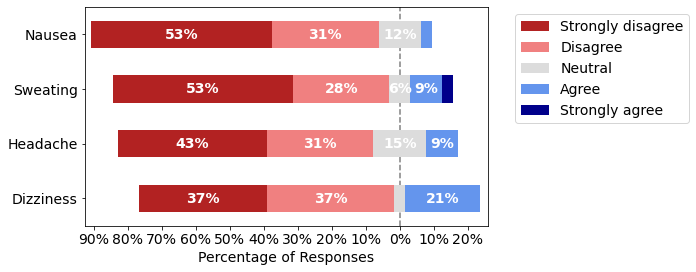

In [ ]:
plt.rcParams.update({'font.size': 14})
scale = \
    ['Strongly disagree',
     'Disagree',
     'Neutral',
     'Agree',
     'Strongly agree']

data_likert = data_responses[[keys_map['nausea'], keys_map['sweating'], keys_map['headache'], keys_map['dizziness']]].copy()
data_likert.columns = ['Nausea', 'Sweating', 'Headache', 'Dizziness']

axes = plk.plot_likert(data_likert, scale, plot_percentage=True, bar_labels=True,
                       bar_labels_color="white",figsize=(10,4))
plt.tight_layout()
plt.savefig('./figures/likert.pdf')

In [ ]:
print(data_likert)
ven_sets = {}

for column in data_likert.keys():
    ven_sets[column] = set()
    for i in np.arange(data_likert.shape[0]):
        if  'Agree'  == data_likert[column][i] or 'Strongly agree' == data_likert[column][i]:
            ven_sets[column].add(i)

print(ven_sets)

               Nausea           Sweating           Headache          Dizziness
0            Disagree  Strongly disagree  Strongly disagree           Disagree
1   Strongly disagree           Disagree            Neutral              Agree
2   Strongly disagree  Strongly disagree  Strongly disagree  Strongly disagree
3             Neutral              Agree           Disagree           Disagree
4             Neutral           Disagree            Neutral              Agree
5   Strongly disagree  Strongly disagree  Strongly disagree  Strongly disagree
6               Agree           Disagree           Disagree              Agree
7            Disagree     Strongly agree              Agree              Agree
8            Disagree              Agree           Disagree              Agree
9            Disagree           Disagree           Disagree           Disagree
10  Strongly disagree  Strongly disagree  Strongly disagree           Disagree
11  Strongly disagree  Strongly disagree  Strongly d

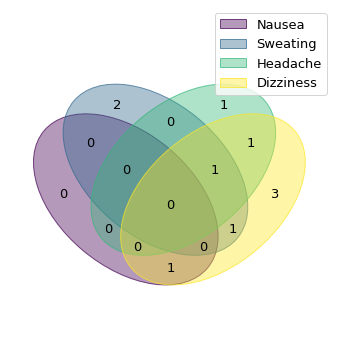

In [ ]:
%matplotlib inline
from venn import venn

venn(ven_sets,figsize=(9,6),legend_loc='best')
plt.savefig("./figures/cybersickness_venn.pdf")

### presence

In [ ]:
data_presence = data_responses[keys_map['presence']].value_counts()

cols_presence = ['Strongly disagree', 'Disagree', 'Neutral', 'Agree', 'Strongly agree']
data_presence = data_presence[cols_presence]
data_presence

Strongly disagree     4
Disagree              5
Neutral              11
Agree                11
Strongly agree        1
Name: How would you describe the general experience? [I felt the objects were part of the real environment], dtype: int64

<AxesSubplot:ylabel='# of responses'>

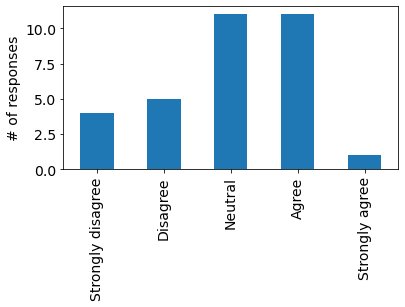

In [ ]:
data_presence.plot(kind='bar', figsize=(6,3), ylabel= '# of responses')

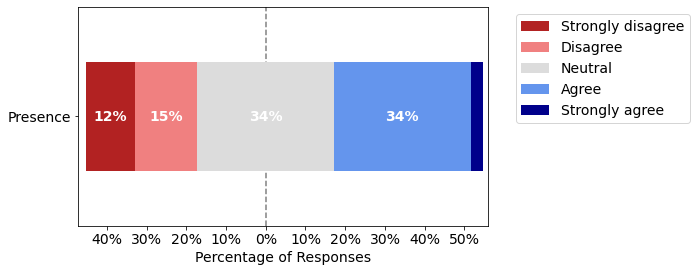

In [ ]:
plt.rcParams.update({'font.size': 14})
data_presence = data_responses[[keys_map['presence']]].copy()
data_presence.columns = ['Presence']

axes = plk.plot_likert(data_presence, scale, plot_percentage=True, bar_labels=True,
                       bar_labels_color="white",figsize=(10,4))
plt.tight_layout()
plt.savefig('./figures/presence.pdf')

In [ ]:
frequencies = ['Never', 'Once', 'A few times', 'Daily', 'Weekly', 'Monthly']
data_frequency = data_responses[[keys_map['frequency'], keys_map['presence']]]
data_frequency.columns = ['Frequency', 'Presence level']
data_frequency

,Frequency,Presence level
0,A few times,Neutral
1,A few times,Agree
2,Never,Strongly disagree
3,Never,Disagree
4,Never,Disagree
5,Monthly,Agree
6,Never,Strongly disagree
7,A few times,Neutral
8,A few times,Disagree
9,A few times,Neutral


In [ ]:
frequency_series = data_frequency.groupby(['Frequency', 'Presence level']).size()
frequency_series = frequency_series.to_frame(name='Counts').reset_index()
frequency_series

,Frequency,Presence level,Counts
0,A few times,Agree,5
1,A few times,Disagree,2
2,A few times,Neutral,9
3,A few times,Strongly agree,1
4,A few times,Strongly disagree,1
5,Monthly,Agree,1
6,Monthly,Strongly disagree,1
7,Never,Agree,1
8,Never,Disagree,3
9,Never,Neutral,1


In [ ]:
pivot = frequency_series.pivot(index=['Frequency'], columns=['Presence level'], values='Counts')
pivot

Presence level,Agree,Disagree,Neutral,Strongly agree,Strongly disagree
Frequency,,,,,
A few times,5.0,2.0,9.0,1.0,1.0
Monthly,1.0,NaN,NaN,NaN,1.0
Never,1.0,3.0,1.0,NaN,2.0
Once,4.0,NaN,NaN,NaN,NaN
Weekly,NaN,NaN,1.0,NaN,NaN


In [ ]:
pivot = pivot[cols_presence].reindex(frequencies).fillna(0)
pivot

Presence level,Strongly disagree,Disagree,Neutral,Agree,Strongly agree
Frequency,,,,,
Never,2.0,3.0,1.0,1.0,0.0
Once,0.0,0.0,0.0,4.0,0.0
A few times,1.0,2.0,9.0,5.0,1.0
Daily,0.0,0.0,0.0,0.0,0.0
Weekly,0.0,0.0,1.0,0.0,0.0
Monthly,1.0,0.0,0.0,1.0,0.0


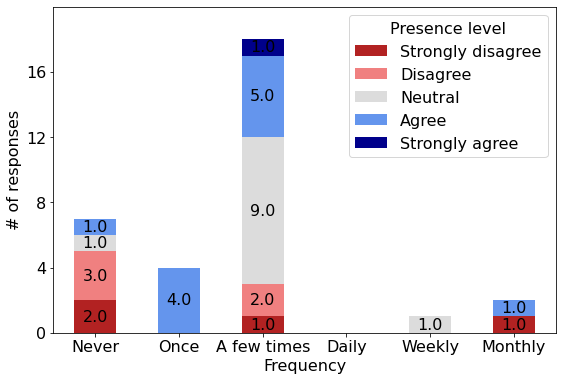

In [ ]:
plt.rcParams.update({'font.size': 16})

plot_likert_colors = [
    "firebrick",
    "lightcoral",
    "gainsboro",
    "cornflowerblue",
    "darkblue",
]

ax = pivot.plot.bar(stacked=True, figsize=(9,6), color=plot_likert_colors)
ax.set_xticklabels(frequencies, rotation=0)
ax.set_ylabel('# of responses')
ax.set_ylim([0,20])
ax.set_yticks(np.arange(0,20,4))

# iterate through each container
for c in ax.containers:

    # Optional: if the segment is small or 0, customize the labels
    labels = [v.get_height() if v.get_height() > 0 else '' for v in c]
    # remove the labels parameter if it's not needed for customized labels
    ax.bar_label(c, labels=labels, label_type='center')
plt.savefig('./figures/presence_frequency.pdf')

None
             Presence level
Frequency                  
A few times              18
Monthly                   2
Never                     7
Once                      4
Weekly                    1
             Presence level
Frequency                  
Never                     7
Once                      4
A few times              18
Weekly                    1
Monthly                   2


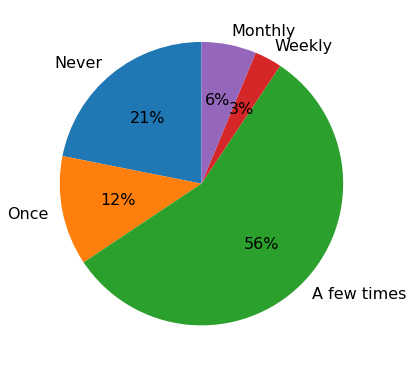

In [ ]:
frequency_statics_ = data_frequency.groupby(['Frequency']).count()
new_fr = frequencies.copy()
print(new_fr.remove('Daily'))
print(frequency_statics_)

frequency_statics = frequency_statics_.reindex(new_fr).fillna(0)
print(frequency_statics)

def absolute_value(val):
    a = np.round(val/100.0*frequency_statics['Presence level'].sum(), 0)
    return a

plt.figure(figsize=(6,6))
plt.pie(frequency_statics['Presence level'],labels=new_fr, startangle=90, autopct='%1d%%')
plt.tight_layout()
plt.savefig('./figures/frequency.pdf')

# ITU-T P.1203

In [69]:
from itu_p1203 import P1203Standalone
from itu_p1203 import P1203Pq
from itu_p1203 import P1203Pa
from itu_p1203 import P1203Pv
from itertools import permutations

import json


In [70]:
f = open("/Users/minhkstn/Documents/mode0.json")
input_data = json.load(f)
input_data

{'I11': {'segments': [], 'streamId': 42},
 'I13': {'segments': [{'codec': 'h264',
    'start': 0,
    'duration': 5,
    'resolution': '1920x1080',
    'bitrate': 16680,
    'fps': 30},
   {'codec': 'h264',
    'start': 5,
    'duration': 10,
    'resolution': '1920x1080',
    'bitrate': 16680,
    'fps': 30}],
  'streamId': 42},
 'I23': {'stalling': [], 'streamId': 42},
 'IGen': {'device': 'pc',
  'displaySize': '1920x1080',
  'viewingDistance': '150cm'}}

In [51]:
bitratesMbps = {
    'longdress': {'r1': 4.64, 'r3': 14.05, 'r5':46.78},
    'loot': {'r1': 2.28, 'r3': 5.63, 'r5': 16.68},
    'redandblack': {'r1': 3.39, 'r3': 7.55, 'r5': 22.9},
    'soldier': {'r1': 4.38, 'r3': 11.58, 'r5': 35.29}
}
distance_map = {'d125': 1.25, 'd250': 2.5, 'd500': 5}

In [160]:
p1203_results = {
    'video': [],
    'start_quality': [],
    'end_quality': [],
    'start_bitrate': [],
    'end_bitrate': [],
    'p1203_qoe': []
}

for video in list(bitratesMbps.keys()):
    bitrate_permutations = permutations(list(bitratesMbps[video].values()), 2)
    quality_permutations = permutations(list(bitratesMbps[video].keys()), 2)

    bitrates = list(bitrate_permutations)
    qualities = list(quality_permutations)
    for bitrate in list(bitratesMbps[video].values()):
        bitrates.append((bitrate, bitrate))

    for quality in list(bitratesMbps[video].keys()):
        qualities.append((quality, quality))
    
    for bitrate, quality in zip(bitrates, qualities):
        p1203_results['video'].append(video)
        p1203_results['start_quality'].append(quality[0])
        p1203_results['end_quality'].append(quality[1])
        p1203_results['start_bitrate'].append(bitrate[0])
        p1203_results['end_bitrate'].append(bitrate[1])

        input_data['I13']['segments'][0]['bitrate'] = bitrate[0]
        input_data['I13']['segments'][1]['bitrate'] = bitrate[1]
        p1203_results['p1203_qoe'].append(P1203Standalone(input_data).calculate_complete()['O46'])

# p1203_results

WARNING - p1203Pq - O21 has no scores, will assume constant high quality audio.
WARNING - p1203Pq - O21 has no scores, will assume constant high quality audio.
WARNING - p1203Pq - O21 has no scores, will assume constant high quality audio.
WARNING - p1203Pq - O21 has no scores, will assume constant high quality audio.
WARNING - p1203Pq - O21 has no scores, will assume constant high quality audio.
WARNING - p1203Pq - O21 has no scores, will assume constant high quality audio.
WARNING - p1203Pq - O21 has no scores, will assume constant high quality audio.
WARNING - p1203Pq - O21 has no scores, will assume constant high quality audio.
WARNING - p1203Pq - O21 has no scores, will assume constant high quality audio.
WARNING - p1203Pq - O21 has no scores, will assume constant high quality audio.
WARNING - p1203Pq - O21 has no scores, will assume constant high quality audio.
WARNING - p1203Pq - O21 has no scores, will assume constant high quality audio.
WARNING - p1203Pq - O21 has no scores, w

In [161]:
p1203_df = pd.DataFrame.from_dict(p1203_results)
p1203_df

,video,start_quality,end_quality,start_bitrate,end_bitrate,p1203_qoe
0,longdress,r1,r3,4.64,14.05,3.690883
1,longdress,r1,r5,4.64,46.78,4.079285
2,longdress,r3,r1,14.05,4.64,3.304217
3,longdress,r3,r5,14.05,46.78,4.307160
4,longdress,r5,r1,46.78,4.64,3.330890
5,longdress,r5,r3,46.78,14.05,3.938712
6,longdress,r1,r1,4.64,4.64,3.215482
7,longdress,r3,r3,14.05,14.05,3.866217
8,longdress,r5,r5,46.78,46.78,4.429231
9,loot,r1,r3,2.28,5.63,3.027534


In [186]:
p1203_df_1 = p1203_df.loc[p1203_df['video'].isin(['longdress', 'loot'])]
grouped_p1203_qoe = p1203_df_1.groupby(['video', 'start_quality', 'end_quality'])
grouped_p1203_qoe = grouped_p1203_qoe.mean()
grouped_p1203_qoe


start_bitrate  end_bitrate  p1203_qoe
video     start_quality end_quality                                       
longdress r1            r1                    4.64         4.64   3.215482
                        r3                    4.64        14.05   3.690883
                        r5                    4.64        46.78   4.079285
          r3            r1                   14.05         4.64   3.304217
                        r3                   14.05        14.05   3.866217
                        r5                   14.05        46.78   4.307160
          r5            r1                   46.78         4.64   3.330890
                        r3                   46.78        14.05   3.938712
                        r5                   46.78        46.78   4.429231
loot      r1            r1                    2.28         2.28   2.508766
                        r3                    2.28         5.63   3.027534
                        r5                    2.28        16.68   3.407702
          r3            r1                    5.63         2.28   2.605830
                        r3                    5.63         5.63   3.365742
                        r5                    5.63        16.68   3.774620
          r5            r1                   16.68         2.28   2.668795
                        r3                   16.68         5.63   3.443252
                        r5                   16.68        16.68   3.945552

In [213]:
p1203_qoe = list(grouped_p1203_qoe['p1203_qoe'])
p1203_qoe

[3.2154821952650363,
 3.690883083369825,
 4.079285432613247,
 3.3042166383720093,
 3.866216793115387,
 4.307160108292813,
 3.3308902302700214,
 3.9387119235097026,
 4.429231065829803,
 2.508765951559999,
 3.0275343358572644,
 3.4077024885524674,
 2.6058295218475362,
 3.3657420897110026,
 3.774619674526409,
 2.668795222578421,
 3.4432524858516227,
 3.9455523161635666]

In [205]:
import pandas as pd
import numpy as np
# get input data
df = pd.read_csv('./results/ratings.csv')
df

,user,objects,qoe,time
0,19,Soldier_r3_r3_d500,7,2023-03-20-09:29:29+01:00
1,19,Soldier_r3_r3_d250,5,2023-03-20-09:29:47+01:00
2,19,RedAndBlack_r3_r3_d125,5,2023-03-20-09:30:01+01:00
3,19,Soldier_r5_r5_d250,7,2023-03-20-09:30:16+01:00
4,19,Soldier_r5_r5_d500,8,2023-03-20-09:30:30+01:00
...,...,...,...,...
1147,56,Loot_r3_r3_d500,6,2023-03-31-15:47:04+02:00
1148,56,LongDress_r1_r5_d500,5,2023-03-31-15:47:17+02:00
1149,56,Loot_r1_r5_d500,4,2023-03-31-15:47:34+02:00
1150,56,Loot_r3_r1_d500,4,2023-03-31-15:47:45+02:00


In [209]:
df[['object', 'start_quality', 'end_quality', 'distance']] = df.objects.str.split('_', expand=True)
df['object'] = df['object'].str.lower()
df['qoe_'] = df['qoe'].apply(lambda x: x*0.5)
df

,user,objects,qoe,time,object,start_quality,end_quality,distance,qoe_
0,19,Soldier_r3_r3_d500,7,2023-03-20-09:29:29+01:00,soldier,r3,r3,d500,3.5
1,19,Soldier_r3_r3_d250,5,2023-03-20-09:29:47+01:00,soldier,r3,r3,d250,2.5
2,19,RedAndBlack_r3_r3_d125,5,2023-03-20-09:30:01+01:00,redandblack,r3,r3,d125,2.5
3,19,Soldier_r5_r5_d250,7,2023-03-20-09:30:16+01:00,soldier,r5,r5,d250,3.5
4,19,Soldier_r5_r5_d500,8,2023-03-20-09:30:30+01:00,soldier,r5,r5,d500,4.0
...,...,...,...,...,...,...,...,...,...
1147,56,Loot_r3_r3_d500,6,2023-03-31-15:47:04+02:00,loot,r3,r3,d500,3.0
1148,56,LongDress_r1_r5_d500,5,2023-03-31-15:47:17+02:00,longdress,r1,r5,d500,2.5
1149,56,Loot_r1_r5_d500,4,2023-03-31-15:47:34+02:00,loot,r1,r5,d500,2.0
1150,56,Loot_r3_r1_d500,4,2023-03-31-15:47:45+02:00,loot,r3,r1,d500,2.0


In [210]:
df = df.loc[df['object'].isin(['longdress', 'loot'])]
grouped_ground_truth = df.groupby(['object', 'start_quality', 'end_quality'])
grouped_ground_truth = grouped_ground_truth.mean()

In [211]:
qoe_ground_truth = list(grouped_ground_truth['qoe_'])
qoe_ground_truth

[2.109375,
 2.375,
 2.578125,
 2.3125,
 2.984375,
 3.109375,
 2.546875,
 3.15625,
 3.515625,
 2.265625,
 2.609375,
 2.796875,
 2.5625,
 3.453125,
 3.546875,
 2.5625,
 3.671875,
 3.765625]

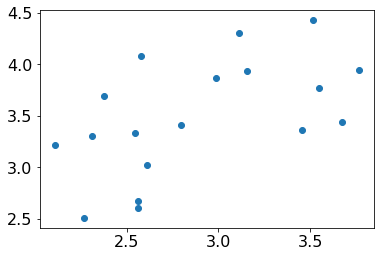

In [212]:
plt.scatter(qoe_ground_truth, p1203_qoe)

/Users/minhkstn/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


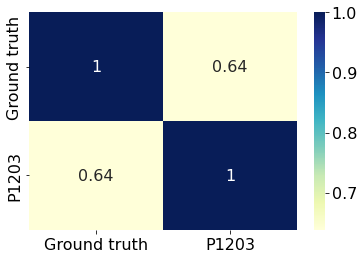

In [215]:
import seaborn as sns
df_correlation = pd.DataFrame({'Ground truth': qoe_ground_truth,
                              'P1203': p1203_qoe})

corr = df_correlation.corr(method = 'spearman')

sns.heatmap(corr, cmap='YlGnBu', annot = True)
# plt.savefig("./figures/correlation_spearman.pdf")
plt.show()